<a href="https://colab.research.google.com/github/annahanslc/koi-price-prediction/blob/main/2_Baseline_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Koi Variety Classification

--------
### Notebook # 2 - Baseline Model


--------

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, glob, shutil

import keras
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2

from sklearn.model_selection import train_test_split

sys.path.append("/content/drive/MyDrive/Colab Notebooks/project_koi_classification/src")
from helpers import *
from deep_functions import *

In [ ]:
# Mount google drive

from google.colab import drive
drive.mount('/content/drive')

# Define dataset path

drive_path = "/content/drive/MyDrive/Colab Notebooks/project_koi_classification/data"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Copy folder from google drive to local storage for faster processing unless folder is already there

drive_path = "/content/drive/MyDrive/Colab Notebooks/project_koi_classification/data"
local_path = "/content/koi_data"


if not os.path.exists(local_path):
    shutil.copytree(drive_path, local_path)
    print(f"Dataset copied to local storage at: {local_path}")
else:
    print(f"Dataset already exists at: {local_path}")

Dataset already exists at: /content/koi_data


-------
# Train/Test/Val Split

-------

In [ ]:
# Split into train/test/val

image_paths = []
labels = []

class_names = sorted(os.listdir(local_path))  # sorted ensures label consistency

# Get the file paths and labels manually

for label, class_name in enumerate(class_names):
    class_dir = os.path.join(local_path, class_name)
    if os.path.isdir(class_dir):
        for img_file in glob.glob(os.path.join(class_dir, "*")):
            if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(img_file)
                labels.append(label)

In [ ]:
# Create a dictionary to map class names to their label

class_dict = {i: class_name for i, class_name in enumerate(class_names)}
class_dict

{0: 'Asagi',
 1: 'Hikarimoyo',
 2: 'Hikarimuji mono',
 3: 'Kin-Ginrin',
 4: 'Kohaku',
 5: 'Sanke',
 6: 'Showa',
 7: 'Shusui',
 8: 'Tancho',
 9: 'Utsuri'}

In [ ]:
# First split: train vs (val + test)
X_train_paths, X_test_paths, y_train, y_test = train_test_split(image_paths, labels, test_size=0.3, stratify=labels, random_state=42)

# Second split: train vs val
X_test_paths, X_val_paths, y_test, y_val = train_test_split(X_test_paths, y_test, test_size=0.5, stratify=y_test, random_state=42)

In [ ]:
# Check the paths

X_train_paths[:10]

['/content/koi_data/Tancho/8.jpg',
 '/content/koi_data/Tancho/30.jpg',
 '/content/koi_data/Shusui/43.jpg',
 '/content/koi_data/Kohaku/49.jpg',
 '/content/koi_data/Utsuri/62.jpg',
 '/content/koi_data/Shusui/7.jpg',
 '/content/koi_data/Kohaku/85.jpg',
 '/content/koi_data/Kohaku/66.jpg',
 '/content/koi_data/Hikarimoyo/6.jpg',
 '/content/koi_data/Asagi/69.jpg']

In [ ]:
# Check the shapes

print(f"""
X_train length: {len(X_train_paths)}, y_train length: {len(y_train)}
X_test length: {len(X_test_paths)}, y_test length: {len(y_test)}
X_val length: {len(X_val_paths)}, y_val length: {len(y_val)}
""")


X_train length: 565, y_train length: 565
X_test length: 121, y_test length: 121
X_val length: 122, y_val length: 122



In [ ]:
# Define constant variables

IMG_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3)
BATCH_SIZE = 16

In [ ]:
# Create a function to process images into raw tensor

def process_image(file_path, label):
  img = tf.io.read_file(file_path)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.resize(img, IMG_SIZE)
  img.set_shape(INPUT_SHAPE)

  return img, label

In [ ]:
# Test the process_image function

X_0, y_0 = process_image(X_train_paths[0], y_train[0])
ds_0 = tf.data.Dataset.from_tensor_slices(([X_0], [y_0]))
ds_0

<_TensorSliceDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [ ]:
# Use the process_image function on all data sets

X_train_raw, y_train = zip(*[process_image(path, label) for path, label in zip(X_train_paths, y_train)])
X_test_raw, y_test = zip(*[process_image(path, label) for path, label in zip(X_test_paths, y_test)])
X_val_raw, y_val = zip(*[process_image(path, label) for path, label in zip(X_val_paths, y_val)])

In [ ]:
# Create tensorflow dataset using the raw tensors

train_ds = tf.data.Dataset.from_tensor_slices((list(X_train_raw), list(y_train)))
test_ds = tf.data.Dataset.from_tensor_slices((list(X_test_raw), list(y_test)))
val_ds = tf.data.Dataset.from_tensor_slices((list(X_val_raw), list(y_val)))

In [ ]:
# Optimize the datasets

train_ds = train_ds.cache().shuffle(len(X_train_raw)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Label = 7: Shusui


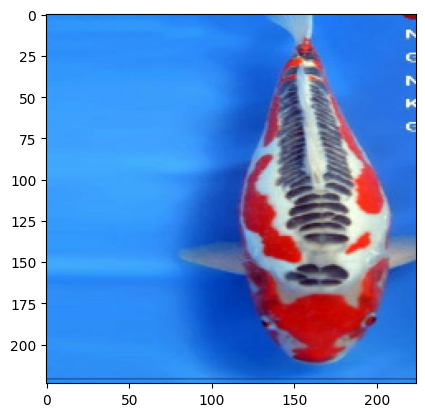

Label = 2: Hikarimuji mono


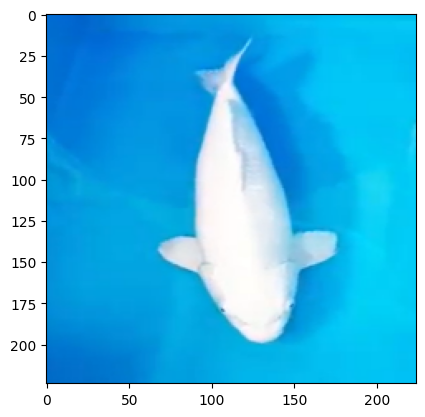

Label = 0: Asagi


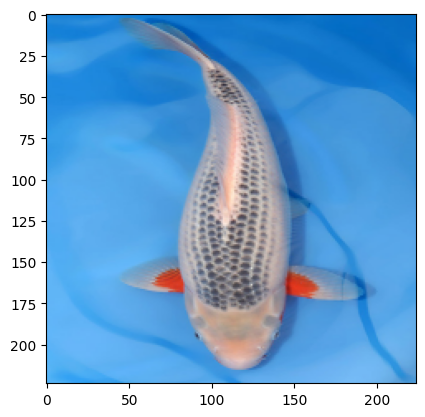

In [ ]:
# Check out 3 samples from train_ds

for images, labels in train_ds.take(1):
  for i in range(3):
    plt.imshow(images[i].numpy().astype("uint8"))
    print(f'Label = {labels[i].numpy()}: {class_dict[labels[i].numpy()]}')
    plt.show()

-------
# Baseline Model

-------

In [ ]:
# Use ResNet for transfer learning for baseline model

resnet50v2_pretrained = keras.applications.ResNet50V2(include_top=False,
                                           weights="imagenet",
                                           input_tensor=None,
                                           input_shape=INPUT_SHAPE,
                                           pooling='avg',
                                           name="resnet50v2",
                                           )

resnet50v2_pretrained.trainable = False


94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Use ResNet50V2's preprocessing

from tensorflow.keras.applications.resnet_v2 import preprocess_input

resnetv2_preprocessor = preprocess_input

In [ ]:
# Build baseline model

def build_model_1_baseline():
  model = Sequential()
  model.add(Input(shape=INPUT_SHAPE))
  model.add(Lambda(resnetv2_preprocessor))
  model.add(resnet50v2_pretrained)
  model.add(Dense(32, activation='relu'))
  model.add(Dense(len(class_names), activation='softmax'))

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  model.summary()
  return model


In [ ]:
# Make an instance of the model

model_1_baseline = build_model_1_baseline()
model_1_baseline.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 2048)           │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        65,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,630,698 (90.14 MB)

 Trainable params: 65,898 (257.41 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 2048)           │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        65,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,630,698 (90.14 MB)

 Trainable params: 65,898 (257.41 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [ ]:
# Fit the model

history_1_baseline = model_1_baseline.fit(train_ds, validation_data=test_ds, epochs=25,
                                          callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])

Epoch 1/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 25s 359ms/step - accuracy: 0.2988 - loss: 2.0930 - val_accuracy: 0.6281 - val_loss: 1.1808
Epoch 2/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7102 - loss: 0.9228 - val_accuracy: 0.6942 - val_loss: 0.8274
Epoch 3/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8276 - loss: 0.5769 - val_accuracy: 0.7521 - val_loss: 0.7349
Epoch 4/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8898 - loss: 0.4048 - val_accuracy: 0.8264 - val_loss: 0.6230
Epoch 5/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9261 - loss: 0.2835 - val_accuracy: 0.7851 - val_loss: 0.5685
Epoch 6/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9674 - loss: 0.2138 - val_accuracy: 0.8264 - val_loss: 0.5018
Epoch 7/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9816 - loss: 0.1572 - val_accuracy: 0.7851 - val_loss: 0.5738
Epoch 8/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9674 - loss: 0.1295 - val_accuracy: 0.8347 -


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        48
           1       1.00      1.00      1.00        42
           2       1.00      1.00      1.00        75
           3       0.93      1.00      0.96        38
           4       1.00      0.96      0.98        78
           5       1.00      1.00      1.00        63
           6       0.99      1.00      0.99        76
           7       1.00      1.00      1.00        44
           8       1.00      0.98      0.99        57
           9       1.00      1.00      1.00        44

    accuracy                           0.99       565
   macro avg       0.99      0.99      0.99       565
weighted avg       0.99      0.99      0.99       565



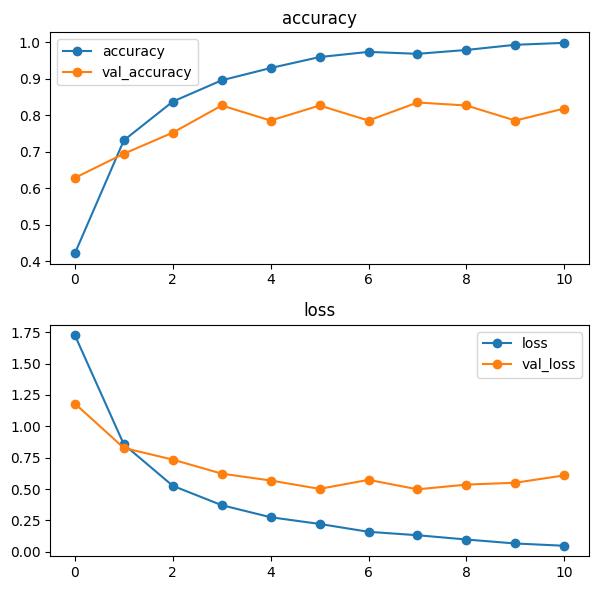

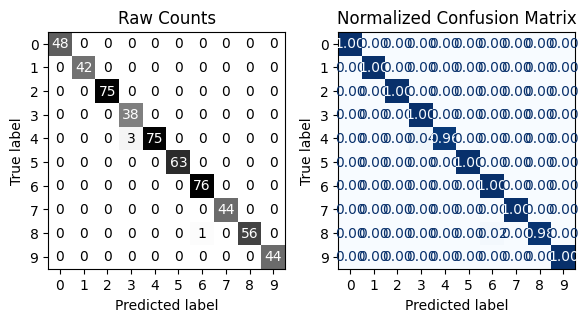

----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       1.00      0.78      0.88         9
           2       1.00      1.00      1.00        16
           3       0.56      0.56      0.56         9
           4       0.93      0.81      0.87        16
           5       0.80      0.92      0.86        13
           6       0.74      0.88      0.80        16
           7       0.83      1.00      0.91        10
           8       0.71      0.42      0.53        12
           9       0.91      1.00      0.95        10

    accuracy                           0.83       121
   macro avg       0.83      0.83      0.82       121
weighted avg       0.84      0.83      0.83       121



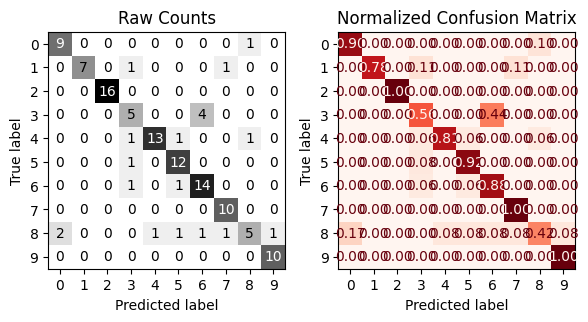

In [ ]:
# Evaluate the results

train_dict, test_dict = evaluate_classification_network(model_1_baseline,
                                                        X_train=train_ds,
                                                        X_test=test_ds,
                                                        history=history_1_baseline,
                                                        output_dict=True)

In [ ]:
# Use helper function to get results in a DataFrame

results_model_1_baseline = make_results_df(train_dict, test_dict)
results_model_1_baseline

precision    recall  f1-score     support
Train 0              1.000000  1.000000  1.000000   48.000000
      1              1.000000  1.000000  1.000000   42.000000
      2              1.000000  1.000000  1.000000   75.000000
      3              0.926829  1.000000  0.962025   38.000000
      4              1.000000  0.961538  0.980392   78.000000
      5              1.000000  1.000000  1.000000   63.000000
      6              0.987013  1.000000  0.993464   76.000000
      7              1.000000  1.000000  1.000000   44.000000
      8              1.000000  0.982456  0.991150   57.000000
      9              1.000000  1.000000  1.000000   44.000000
      accuracy       0.992920  0.992920  0.992920    0.992920
      macro avg      0.991384  0.994399  0.992703  565.000000
      weighted avg   0.993332  0.992920  0.992967  565.000000
Test  0              0.818182  0.900000  0.857143   10.000000
      1              1.000000  0.777778  0.875000    9.000000
      2              1.000000  1.000000  1.000000   16.000000
      3              0.555556  0.555556  0.555556    9.000000
      4              0.928571  0.812500  0.866667   16.000000
      5              0.800000  0.923077  0.857143   13.000000
      6              0.736842  0.875000  0.800000   16.000000
      7              0.833333  1.000000  0.909091   10.000000
      8              0.714286  0.416667  0.526316   12.000000
      9              0.909091  1.000000  0.952381   10.000000
      accuracy       0.834711  0.834711  0.834711    0.834711
      macro avg      0.829586  0.826058  0.819930  121.000000
      weighted avg   0.836563  0.834711  0.827987  121.000000

Observations:

The train data continues improving until it reached a plateau, but the test data does not show consistent improvement beyond the initial epoch. The model is overfit. Next, I will normalize the model to reduce overfitting.

-------
# Model 2: Reduce Overfitting

### a) Reduce model complexity: change 32 units to 16

-------

In [ ]:
# Build model

def build_model_2():
  model = Sequential()
  model.add(Input(shape=INPUT_SHAPE))
  model.add(Lambda(resnetv2_preprocessor))
  model.add(resnet50v2_pretrained)
  model.add(Dense(16, activation='relu'))
  model.add(Dense(len(class_names), activation='softmax'))

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  model.summary()
  return model


# Make an instance of the model

model_2 = build_model_2()
model_2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_1 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 2048)           │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │        32,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,597,754 (90.02 MB)

 Trainable params: 32,954 (128.73 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_1 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 2048)           │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │        32,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,597,754 (90.02 MB)

 Trainable params: 32,954 (128.73 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [ ]:
# Fit the model

history_2 = model_2.fit(train_ds, validation_data=test_ds, epochs=25,
                        callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])

Epoch 1/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 283ms/step - accuracy: 0.2938 - loss: 2.1390 - val_accuracy: 0.4711 - val_loss: 1.3722
Epoch 2/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5292 - loss: 1.2158 - val_accuracy: 0.6529 - val_loss: 1.0196
Epoch 3/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7412 - loss: 0.8004 - val_accuracy: 0.7521 - val_loss: 0.7991
Epoch 4/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8464 - loss: 0.5488 - val_accuracy: 0.7934 - val_loss: 0.6753
Epoch 5/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9038 - loss: 0.4233 - val_accuracy: 0.7934 - val_loss: 0.6486
Epoch 6/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9409 - loss: 0.3002 - val_accuracy: 0.8347 - val_loss: 0.6029
Epoch 7/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9606 - loss: 0.2290 - val_accuracy: 0.7851 - val_loss: 0.5758
Epoch 8/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9744 - loss: 0.1857 - val_accuracy: 0.8182 -


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        48
           1       1.00      1.00      1.00        42
           2       1.00      1.00      1.00        75
           3       0.97      0.97      0.97        38
           4       1.00      0.99      0.99        78
           5       1.00      1.00      1.00        63
           6       0.97      1.00      0.99        76
           7       1.00      1.00      1.00        44
           8       1.00      0.98      0.99        57
           9       1.00      1.00      1.00        44

    accuracy                           0.99       565
   macro avg       0.99      0.99      0.99       565
weighted avg       0.99      0.99      0.99       565



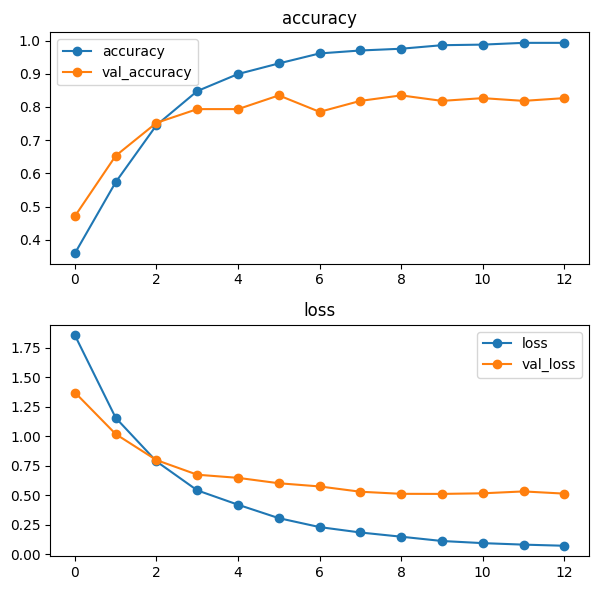

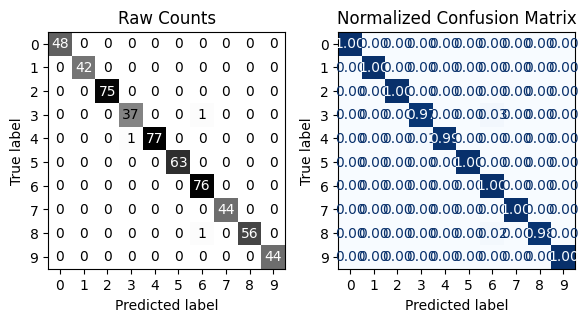

----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.89      0.89      0.89         9
           2       0.93      0.88      0.90        16
           3       0.67      0.44      0.53         9
           4       0.92      0.75      0.83        16
           5       0.73      0.85      0.79        13
           6       0.74      0.88      0.80        16
           7       0.91      1.00      0.95        10
           8       0.69      0.92      0.79        12
           9       1.00      0.70      0.82        10

    accuracy                           0.82       121
   macro avg       0.83      0.81      0.81       121
weighted avg       0.83      0.82      0.82       121



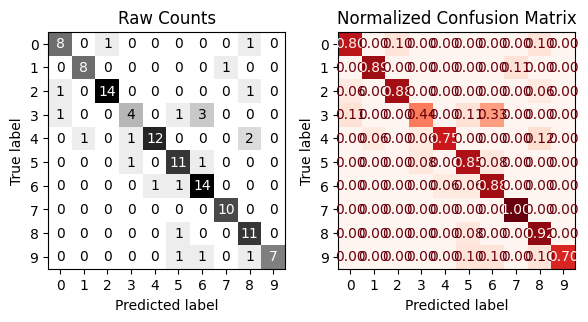

precision    recall  f1-score     support
Train 0              1.000000  1.000000  1.000000   48.000000
      1              1.000000  1.000000  1.000000   42.000000
      2              1.000000  1.000000  1.000000   75.000000
      3              0.973684  0.973684  0.973684   38.000000
      4              1.000000  0.987179  0.993548   78.000000
      5              1.000000  1.000000  1.000000   63.000000
      6              0.974359  1.000000  0.987013   76.000000
      7              1.000000  1.000000  1.000000   44.000000
      8              1.000000  0.982456  0.991150   57.000000
      9              1.000000  1.000000  1.000000   44.000000
      accuracy       0.994690  0.994690  0.994690    0.994690
      macro avg      0.994804  0.994332  0.994540  565.000000
      weighted avg   0.994781  0.994690  0.994700  565.000000
Test  0              0.800000  0.800000  0.800000   10.000000
      1              0.888889  0.888889  0.888889    9.000000
      2              0.933333  0.875000  0.903226   16.000000
      3              0.666667  0.444444  0.533333    9.000000
      4              0.923077  0.750000  0.827586   16.000000
      5              0.733333  0.846154  0.785714   13.000000
      6              0.736842  0.875000  0.800000   16.000000
      7              0.909091  1.000000  0.952381   10.000000
      8              0.687500  0.916667  0.785714   12.000000
      9              1.000000  0.700000  0.823529   10.000000
      accuracy       0.818182  0.818182  0.818182    0.818182
      macro avg      0.827873  0.809615  0.810037  121.000000
      weighted avg   0.829473  0.818182  0.815661  121.000000

In [ ]:
# Evaluate the results

train_dict, test_dict = evaluate_classification_network(model_2,
                                                        X_train=train_ds,
                                                        X_test=test_ds,
                                                        history=history_2,
                                                        output_dict=True)

# Use helper function to get results in a DataFrame

results_model_2 = make_results_df(train_dict, test_dict)
results_model_2

In [ ]:
# Use helper function to compare the current model with the previous model (baseline)

compare_models(results_model_1_baseline, results_model_2)

Train accuracy increased by 0.0017699115044248481
Test accuracy decreased by -0.016528925619834656
Overfitting increased by 0.018298837124259504
*Overfitting is calculated as train accuracy - test acccuracy


Observations:

- The model is still overfitting. I will implement additional measures to address overfitting.

-------
# Model 3: Reduce Overfitting

### a) (KEEP) Reduce model complexity: change 32 units to 16
### b) (NEW) Add data augmentation to prevent the model from memorizing fixed patterns

-------

In [ ]:
# Define a data augmentation layer

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1)
], name='data_augmentation')


# Build model

def build_model_3_augmentation():
  model = Sequential()
  model.add(Input(shape=INPUT_SHAPE))
  model.add(data_augmentation)
  model.add(Lambda(resnetv2_preprocessor))
  model.add(resnet50v2_pretrained)
  model.add(Dense(16, activation='relu'))
  model.add(Dense(len(class_names), activation='softmax'))

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  model.summary()
  return model


# Make an instance of the model

model_3_augmentation = build_model_3_augmentation()
model_3_augmentation.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_2 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 2048)           │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │        32,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,597,754 (90.02 MB)

 Trainable params: 32,954 (128.73 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_2 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 2048)           │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │        32,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,597,754 (90.02 MB)

 Trainable params: 32,954 (128.73 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [ ]:
# Fit the model

history_3 = model_3_augmentation.fit(train_ds, validation_data=test_ds, epochs=25,
                        callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])

Epoch 1/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 98ms/step - accuracy: 0.1508 - loss: 2.3621 - val_accuracy: 0.3058 - val_loss: 1.8748
Epoch 2/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3839 - loss: 1.6830 - val_accuracy: 0.5041 - val_loss: 1.4791
Epoch 3/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5505 - loss: 1.3155 - val_accuracy: 0.7025 - val_loss: 1.1424
Epoch 4/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6852 - loss: 0.9906 - val_accuracy: 0.7025 - val_loss: 0.9462
Epoch 5/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6872 - loss: 0.8694 - val_accuracy: 0.7521 - val_loss: 0.8162
Epoch 6/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7419 - loss: 0.7168 - val_accuracy: 0.7934 - val_loss: 0.7549
Epoch 7/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8074 - loss: 0.6021 - val_accuracy: 0.8017 - val_loss: 0.6658
Epoch 8/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8527 - loss: 0.4831 - val_accuracy: 0.8182 - 


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        48
           1       0.95      1.00      0.98        42
           2       0.97      0.97      0.97        75
           3       0.63      0.84      0.72        38
           4       0.96      0.91      0.93        78
           5       0.96      0.81      0.88        63
           6       0.92      0.89      0.91        76
           7       1.00      0.89      0.94        44
           8       0.93      0.96      0.95        57
           9       0.89      0.95      0.92        44

    accuracy                           0.92       565
   macro avg       0.92      0.92      0.92       565
weighted avg       0.93      0.92      0.92       565



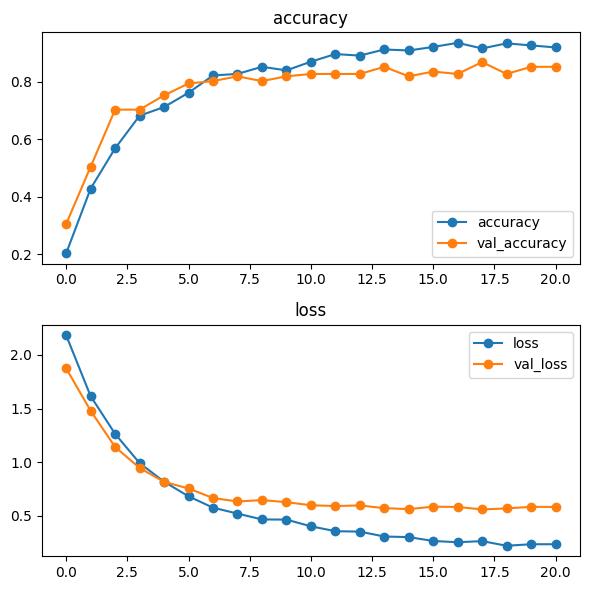

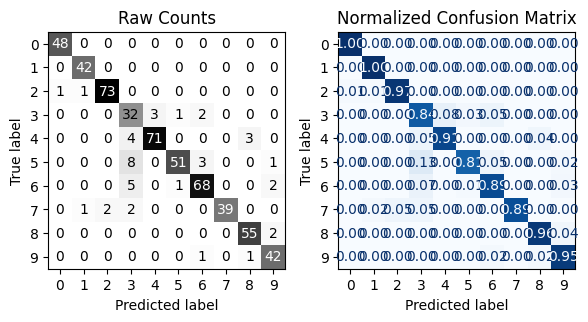

----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       1.00      1.00      1.00         9
           2       0.88      0.88      0.88        16
           3       0.71      0.56      0.62         9
           4       1.00      0.88      0.93        16
           5       0.85      0.85      0.85        13
           6       0.83      0.94      0.88        16
           7       1.00      1.00      1.00        10
           8       0.80      0.67      0.73        12
           9       0.77      1.00      0.87        10

    accuracy                           0.87       121
   macro avg       0.87      0.87      0.86       121
weighted avg       0.87      0.87      0.87       121



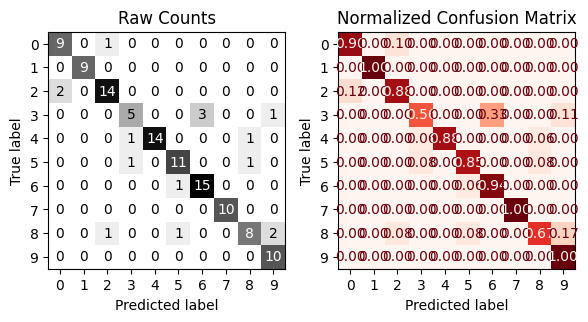

precision    recall  f1-score     support
Train 0              0.979592  1.000000  0.989691   48.000000
      1              0.954545  1.000000  0.976744   42.000000
      2              0.973333  0.973333  0.973333   75.000000
      3              0.627451  0.842105  0.719101   38.000000
      4              0.959459  0.910256  0.934211   78.000000
      5              0.962264  0.809524  0.879310   63.000000
      6              0.918919  0.894737  0.906667   76.000000
      7              1.000000  0.886364  0.939759   44.000000
      8              0.932203  0.964912  0.948276   57.000000
      9              0.893617  0.954545  0.923077   44.000000
      accuracy       0.922124  0.922124  0.922124    0.922124
      macro avg      0.920138  0.923578  0.919017  565.000000
      weighted avg   0.930456  0.922124  0.923969  565.000000
Test  0              0.818182  0.900000  0.857143   10.000000
      1              1.000000  1.000000  1.000000    9.000000
      2              0.875000  0.875000  0.875000   16.000000
      3              0.714286  0.555556  0.625000    9.000000
      4              1.000000  0.875000  0.933333   16.000000
      5              0.846154  0.846154  0.846154   13.000000
      6              0.833333  0.937500  0.882353   16.000000
      7              1.000000  1.000000  1.000000   10.000000
      8              0.800000  0.666667  0.727273   12.000000
      9              0.769231  1.000000  0.869565   10.000000
      accuracy       0.867769  0.867769  0.867769    0.867769
      macro avg      0.865619  0.865588  0.861582  121.000000
      weighted avg   0.869719  0.867769  0.865044  121.000000

In [ ]:
# Evaluate the results

train_dict, test_dict = evaluate_classification_network(model_3_augmentation,
                                                        X_train=train_ds,
                                                        X_test=test_ds,
                                                        history=history_3,
                                                        output_dict=True)

# Use helper function to get results in a DataFrame

results_model_3 = make_results_df(train_dict, test_dict)
results_model_3

In [ ]:
# Use helper function to compare the current model with the baseline model

compare_models(results_model_1_baseline, results_model_3)

Train accuracy decreased by -0.07079646017699115
Test accuracy increased by 0.03305785123966942
Overfitting decreased by -0.10385431141666057
*Overfitting is calculated as train accuracy - test acccuracy


Observations:

Overfitting reduced after implementing data augmentation, but continues to be an issue. I will implement additional measures to address overfitting.

-------
# Model 4: Reduce Overfitting

### a) (KEEP) Reduce model complexity: change 32 units to 16
### b) (KEEP) Add data augmentation to prevent the model from memorizing fixed patterns
### c) (NEW) Add additional data augmentation methods, including RandomContrast and RandomTranslation

-------

In [ ]:
# Define a data augmentation layer

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
    RandomContrast(0.2),
    RandomTranslation(0.1, 0.1)
], name='data_augmentation')


# Build model

def build_model_4_augmentation():
  model = Sequential()
  model.add(Input(shape=INPUT_SHAPE))
  model.add(data_augmentation)
  model.add(Lambda(resnetv2_preprocessor))
  model.add(resnet50v2_pretrained)
  model.add(Dense(16, activation='relu'))
  model.add(Dense(len(class_names), activation='softmax'))

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  model.summary()
  return model


# Make an instance of the model

model_4_augmentation = build_model_4_augmentation()
model_4_augmentation.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_6 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 2048)           │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │        32,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,597,754 (90.02 MB)

 Trainable params: 32,954 (128.73 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_6 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 2048)           │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │        32,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,597,754 (90.02 MB)

 Trainable params: 32,954 (128.73 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [ ]:
# Fit the model

history_4 = model_4_augmentation.fit(train_ds, validation_data=test_ds, epochs=25,
                        callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])

Epoch 1/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.2042 - loss: 2.3906 - val_accuracy: 0.2562 - val_loss: 1.9050
Epoch 2/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.2975 - loss: 1.8526 - val_accuracy: 0.3719 - val_loss: 1.6688
Epoch 3/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4555 - loss: 1.5106 - val_accuracy: 0.4876 - val_loss: 1.3378
Epoch 4/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5691 - loss: 1.2002 - val_accuracy: 0.6529 - val_loss: 1.0721
Epoch 5/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6971 - loss: 0.9579 - val_accuracy: 0.7190 - val_loss: 0.8901
Epoch 6/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7569 - loss: 0.8154 - val_accuracy: 0.6777 - val_loss: 0.8467
Epoch 7/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7906 - loss: 0.7583 - val_accuracy: 0.7273 - val_loss: 0.7664
Epoch 8/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8035 - loss: 0.5726 - val_accuracy: 0.7934 - 


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        48
           1       0.93      0.93      0.93        42
           2       0.99      0.99      0.99        75
           3       0.68      0.71      0.69        38
           4       0.94      0.87      0.91        78
           5       0.92      0.94      0.93        63
           6       0.85      0.92      0.89        76
           7       0.98      1.00      0.99        44
           8       0.93      0.89      0.91        57
           9       0.97      0.89      0.93        44

    accuracy                           0.92       565
   macro avg       0.92      0.91      0.91       565
weighted avg       0.92      0.92      0.92       565



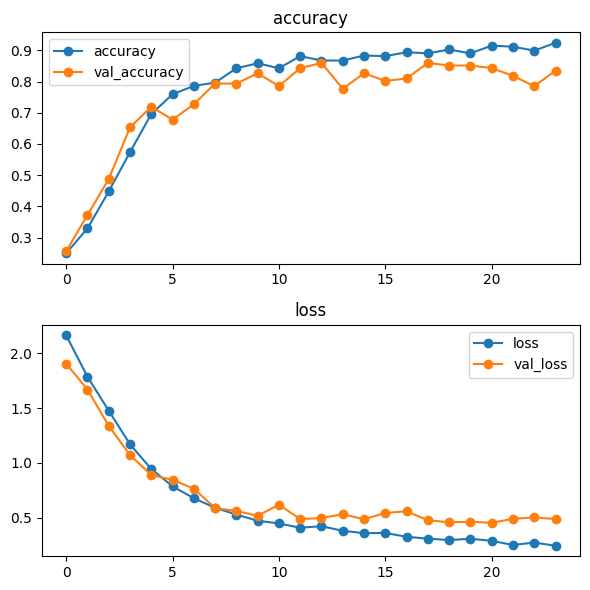

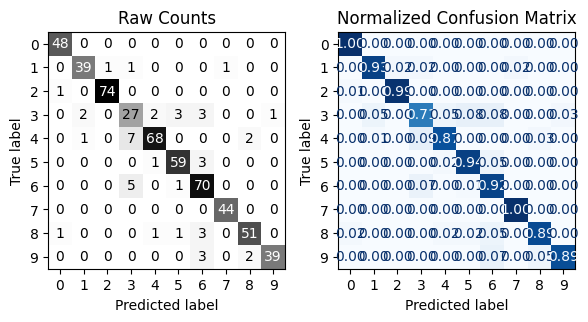

----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.80      0.89      0.84         9
           2       0.94      0.94      0.94        16
           3       0.60      0.67      0.63         9
           4       1.00      0.75      0.86        16
           5       0.80      0.92      0.86        13
           6       0.80      0.75      0.77        16
           7       0.90      0.90      0.90        10
           8       0.90      0.75      0.82        12
           9       0.77      1.00      0.87        10

    accuracy                           0.84       121
   macro avg       0.84      0.85      0.84       121
weighted avg       0.85      0.84      0.84       121



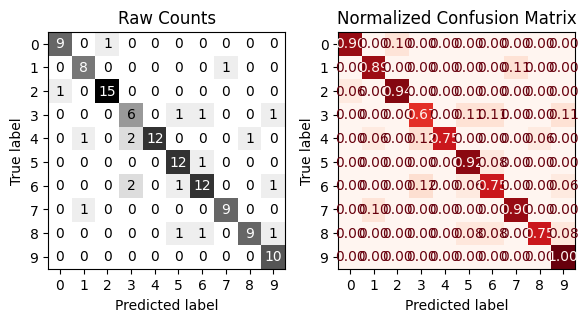

precision    recall  f1-score     support
Train 0              0.960000  1.000000  0.979592   48.000000
      1              0.928571  0.928571  0.928571   42.000000
      2              0.986667  0.986667  0.986667   75.000000
      3              0.675000  0.710526  0.692308   38.000000
      4              0.944444  0.871795  0.906667   78.000000
      5              0.921875  0.936508  0.929134   63.000000
      6              0.853659  0.921053  0.886076   76.000000
      7              0.977778  1.000000  0.988764   44.000000
      8              0.927273  0.894737  0.910714   57.000000
      9              0.975000  0.886364  0.928571   44.000000
      accuracy       0.918584  0.918584  0.918584    0.918584
      macro avg      0.915027  0.913622  0.913706  565.000000
      weighted avg   0.920583  0.918584  0.918936  565.000000
Test  0              0.900000  0.900000  0.900000   10.000000
      1              0.800000  0.888889  0.842105    9.000000
      2              0.937500  0.937500  0.937500   16.000000
      3              0.600000  0.666667  0.631579    9.000000
      4              1.000000  0.750000  0.857143   16.000000
      5              0.800000  0.923077  0.857143   13.000000
      6              0.800000  0.750000  0.774194   16.000000
      7              0.900000  0.900000  0.900000   10.000000
      8              0.900000  0.750000  0.818182   12.000000
      9              0.769231  1.000000  0.869565   10.000000
      accuracy       0.842975  0.842975  0.842975    0.842975
      macro avg      0.840673  0.846613  0.838741  121.000000
      weighted avg   0.853655  0.842975  0.843151  121.000000

In [ ]:
# Evaluate the results

train_dict, test_dict = evaluate_classification_network(model_4_augmentation,
                                                        X_train=train_ds,
                                                        X_test=test_ds,
                                                        history=history_4,
                                                        output_dict=True)

# Use helper function to get results in a DataFrame

results_model_4 = make_results_df(train_dict, test_dict)
results_model_4

In [ ]:
# Use helper function to compare the current model with the previous model

compare_models(results_model_3, results_model_4)

Train accuracy decreased by -0.003539823008849474
Test accuracy decreased by -0.024793388429752095
Overfitting increased by 0.02125356542090262
*Overfitting is calculated as train accuracy - test acccuracy


Observations:

The addition of RandomContrast and RandomTranslation actually increased overfitting. This might be because the random contrast can distort visual features, which is very important in distinguishing between koi varieties. Do determine if this decreased model performance is mostly due to RandomContrast or RandomTranslation, I will remove RandomContrast from the previous model.

-------
# Model 5: Reduce Overfitting

### a) (KEEP) Reduce model complexity: change 32 units to 16
### b) (KEEP) Add data augmentation to prevent the model from memorizing fixed patterns
### c) (KEEP PART) Keep RandomTranslation, Remove RandomContrast

-------

In [ ]:
# Define a data augmentation layer

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
    RandomTranslation(0.1, 0.1)
], name='data_augmentation')


# Build model

def build_model_5_augmentation():
  model = Sequential()
  model.add(Input(shape=INPUT_SHAPE))
  model.add(data_augmentation)
  model.add(Lambda(resnetv2_preprocessor))
  model.add(resnet50v2_pretrained)
  model.add(Dense(16, activation='relu'))
  model.add(Dense(len(class_names), activation='softmax'))

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  model.summary()
  return model


# Make an instance of the model

model_5_augmentation = build_model_5_augmentation()
model_5_augmentation.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_7 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 2048)           │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 16)             │        32,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,597,754 (90.02 MB)

 Trainable params: 32,954 (128.73 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_7 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 2048)           │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 16)             │        32,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,597,754 (90.02 MB)

 Trainable params: 32,954 (128.73 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [ ]:
# Fit the model

history_5 = model_5_augmentation.fit(train_ds, validation_data=test_ds, epochs=25,
                        callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])

Epoch 1/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.2185 - loss: 2.1295 - val_accuracy: 0.5207 - val_loss: 1.4914
Epoch 2/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5468 - loss: 1.3454 - val_accuracy: 0.6694 - val_loss: 1.0269
Epoch 3/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6929 - loss: 0.9204 - val_accuracy: 0.7025 - val_loss: 0.7937
Epoch 4/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7822 - loss: 0.7010 - val_accuracy: 0.7603 - val_loss: 0.6374
Epoch 5/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8223 - loss: 0.6074 - val_accuracy: 0.7521 - val_loss: 0.7130
Epoch 6/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8359 - loss: 0.4949 - val_accuracy: 0.8099 - val_loss: 0.5592
Epoch 7/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8979 - loss: 0.4051 - val_accuracy: 0.8099 - val_loss: 0.5372
Epoch 8/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8738 - loss: 0.3731 - val_accuracy: 0.7851 - 


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.92      0.94        48
           1       0.95      0.86      0.90        42
           2       0.99      0.96      0.97        75
           3       0.81      0.68      0.74        38
           4       0.93      0.83      0.88        78
           5       0.89      0.94      0.91        63
           6       0.83      0.93      0.88        76
           7       0.95      0.89      0.92        44
           8       0.69      0.96      0.80        57
           9       1.00      0.75      0.86        44

    accuracy                           0.88       565
   macro avg       0.90      0.87      0.88       565
weighted avg       0.90      0.88      0.89       565



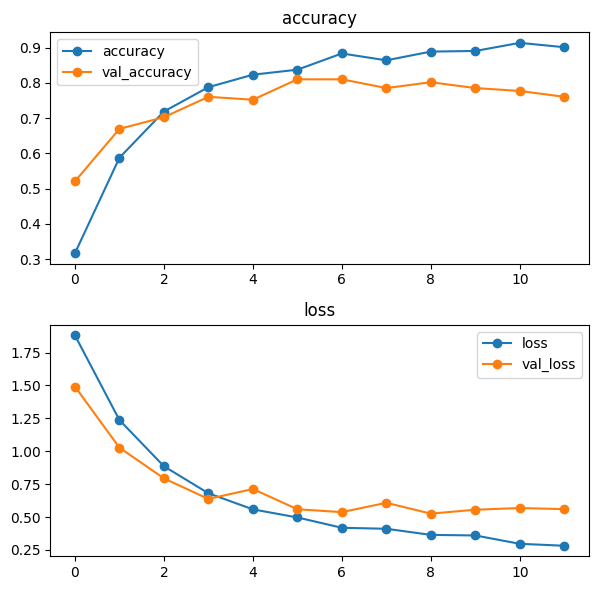

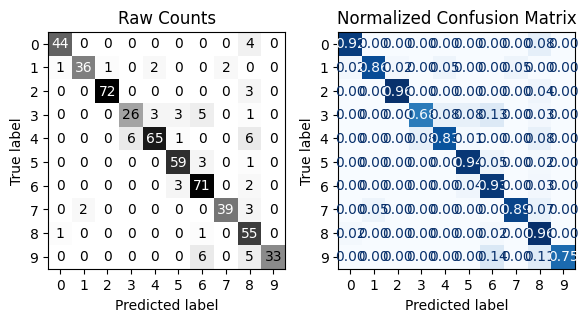

----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.89      0.89      0.89         9
           2       0.88      0.88      0.88        16
           3       0.67      0.44      0.53         9
           4       0.86      0.75      0.80        16
           5       0.73      0.85      0.79        13
           6       0.79      0.94      0.86        16
           7       0.90      0.90      0.90        10
           8       0.67      0.83      0.74        12
           9       0.78      0.70      0.74        10

    accuracy                           0.80       121
   macro avg       0.80      0.79      0.79       121
weighted avg       0.81      0.80      0.80       121



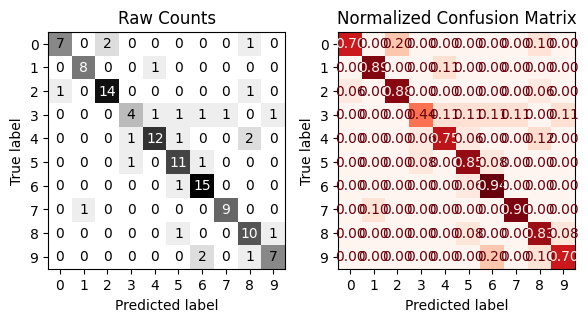

precision    recall  f1-score     support
Train 0              0.956522  0.916667  0.936170   48.000000
      1              0.947368  0.857143  0.900000   42.000000
      2              0.986301  0.960000  0.972973   75.000000
      3              0.812500  0.684211  0.742857   38.000000
      4              0.928571  0.833333  0.878378   78.000000
      5              0.893939  0.936508  0.914729   63.000000
      6              0.825581  0.934211  0.876543   76.000000
      7              0.951220  0.886364  0.917647   44.000000
      8              0.687500  0.964912  0.802920   57.000000
      9              1.000000  0.750000  0.857143   44.000000
      accuracy       0.884956  0.884956  0.884956    0.884956
      macro avg      0.898950  0.872335  0.879936  565.000000
      weighted avg   0.897491  0.884956  0.885936  565.000000
Test  0              0.875000  0.700000  0.777778   10.000000
      1              0.888889  0.888889  0.888889    9.000000
      2              0.875000  0.875000  0.875000   16.000000
      3              0.666667  0.444444  0.533333    9.000000
      4              0.857143  0.750000  0.800000   16.000000
      5              0.733333  0.846154  0.785714   13.000000
      6              0.789474  0.937500  0.857143   16.000000
      7              0.900000  0.900000  0.900000   10.000000
      8              0.666667  0.833333  0.740741   12.000000
      9              0.777778  0.700000  0.736842   10.000000
      accuracy       0.801653  0.801653  0.801653    0.801653
      macro avg      0.802995  0.787532  0.789544  121.000000
      weighted avg   0.805016  0.801653  0.798047  121.000000

In [ ]:
# Evaluate the results

train_dict, test_dict = evaluate_classification_network(model_5_augmentation,
                                                        X_train=train_ds,
                                                        X_test=test_ds,
                                                        history=history_5,
                                                        output_dict=True)

# Use helper function to get results in a DataFrame

results_model_5 = make_results_df(train_dict, test_dict)
results_model_5

In [ ]:
# Use helper function to compare the current model with the best augmentation model (model#3)

compare_models(results_model_3, results_model_5)

Train accuracy decreased by -0.037168141592920256
Test accuracy decreased by -0.06611570247933884
Overfitting increased by 0.02894756088641859
*Overfitting is calculated as train accuracy - test acccuracy


Observation

With only RandomTranslation added to Model#3, Model#5 still shows increase overfitting. To check if this overfitting is actually due to RandomTranslation instead of RandomContrast, I will now add back RandomContrast and remove RandomTranslation. If RandomTranslation is the issued, it might be because key features are being cropped off after the translation.

-------
# Model 6: Reduce Overfitting

### a) (KEEP) Reduce model complexity: change 32 units to 16
### b) (KEEP) Add data augmentation to prevent the model from memorizing fixed patterns
### c) (KEEP PART) Remove RandomTranslation, Keep RandomContrast

-------

In [ ]:
# Define a data augmentation layer

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
    RandomContrast(0.2),
], name='data_augmentation')


# Build model

def build_model_6_augmentation():
  model = Sequential()
  model.add(Input(shape=INPUT_SHAPE))
  model.add(data_augmentation)
  model.add(Lambda(resnetv2_preprocessor))
  model.add(resnet50v2_pretrained)
  model.add(Dense(16, activation='relu'))
  model.add(Dense(len(class_names), activation='softmax'))

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  model.summary()
  return model


# Make an instance of the model

model_6_augmentation = build_model_6_augmentation()
model_6_augmentation.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_8 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 2048)           │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 16)             │        32,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,597,754 (90.02 MB)

 Trainable params: 32,954 (128.73 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_8 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 2048)           │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 16)             │        32,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,597,754 (90.02 MB)

 Trainable params: 32,954 (128.73 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [ ]:
# Fit the model

history_6 = model_6_augmentation.fit(train_ds, validation_data=test_ds, epochs=30,
                        callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])

Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.2646 - loss: 2.1307 - val_accuracy: 0.5124 - val_loss: 1.3822
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6093 - loss: 1.2851 - val_accuracy: 0.7025 - val_loss: 0.9990
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6854 - loss: 0.9622 - val_accuracy: 0.7851 - val_loss: 0.8275
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7396 - loss: 0.7620 - val_accuracy: 0.7355 - val_loss: 0.7990
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7886 - loss: 0.6811 - val_accuracy: 0.7603 - val_loss: 0.7245
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8413 - loss: 0.4890 - val_accuracy: 0.7934 - val_loss: 0.6641
Epoch 7/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8538 - loss: 0.4534 - val_accuracy: 0.7851 - val_loss: 0.6301
Epoch 8/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8870 - loss: 0.4032 - val_accuracy: 0.7521 - 


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        48
           1       0.93      1.00      0.97        42
           2       1.00      0.97      0.99        75
           3       0.83      0.89      0.86        38
           4       0.97      0.88      0.93        78
           5       1.00      0.94      0.97        63
           6       0.95      0.92      0.93        76
           7       1.00      0.95      0.98        44
           8       0.83      0.96      0.89        57
           9       1.00      0.98      0.99        44

    accuracy                           0.95       565
   macro avg       0.95      0.95      0.95       565
weighted avg       0.95      0.95      0.95       565



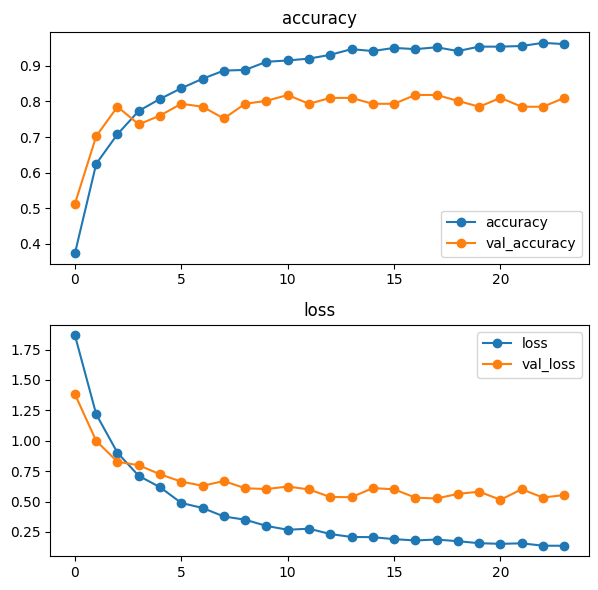

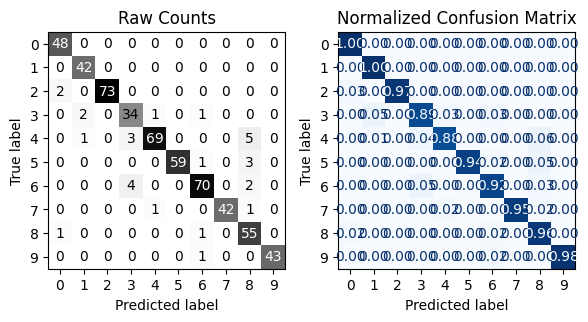

----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9
           2       0.94      0.94      0.94        16
           3       0.67      0.44      0.53         9
           4       0.92      0.75      0.83        16
           5       0.71      0.77      0.74        13
           6       0.74      0.88      0.80        16
           7       0.90      0.90      0.90        10
           8       0.67      0.83      0.74        12
           9       0.89      0.80      0.84        10

    accuracy                           0.81       121
   macro avg       0.81      0.80      0.80       121
weighted avg       0.82      0.81      0.81       121



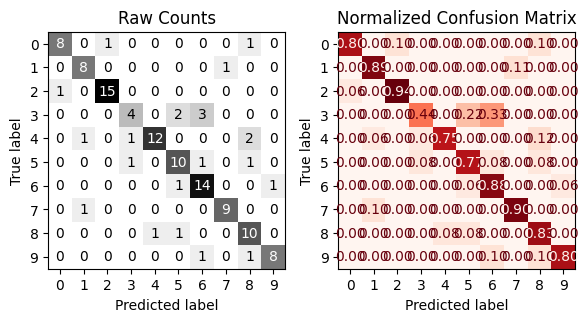

precision    recall  f1-score     support
Train 0              0.941176  1.000000  0.969697   48.000000
      1              0.933333  1.000000  0.965517   42.000000
      2              1.000000  0.973333  0.986486   75.000000
      3              0.829268  0.894737  0.860759   38.000000
      4              0.971831  0.884615  0.926174   78.000000
      5              1.000000  0.936508  0.967213   63.000000
      6              0.945946  0.921053  0.933333   76.000000
      7              1.000000  0.954545  0.976744   44.000000
      8              0.833333  0.964912  0.894309   57.000000
      9              1.000000  0.977273  0.988506   44.000000
      accuracy       0.946903  0.946903  0.946903    0.946903
      macro avg      0.945489  0.950698  0.946874  565.000000
      weighted avg   0.950590  0.946903  0.947519  565.000000
Test  0              0.888889  0.800000  0.842105   10.000000
      1              0.800000  0.888889  0.842105    9.000000
      2              0.937500  0.937500  0.937500   16.000000
      3              0.666667  0.444444  0.533333    9.000000
      4              0.923077  0.750000  0.827586   16.000000
      5              0.714286  0.769231  0.740741   13.000000
      6              0.736842  0.875000  0.800000   16.000000
      7              0.900000  0.900000  0.900000   10.000000
      8              0.666667  0.833333  0.740741   12.000000
      9              0.888889  0.800000  0.842105   10.000000
      accuracy       0.809917  0.809917  0.809917    0.809917
      macro avg      0.812282  0.799840  0.800622  121.000000
      weighted avg   0.816712  0.809917  0.808107  121.000000

In [ ]:
# Evaluate the results

train_dict, test_dict = evaluate_classification_network(model_6_augmentation,
                                                        X_train=train_ds,
                                                        X_test=test_ds,
                                                        history=history_6,
                                                        output_dict=True)

# Use helper function to get results in a DataFrame

results_model_6 = make_results_df(train_dict, test_dict)
results_model_6

In [ ]:
# Use helper function to compare the current model with the best augmentation model (model #3)

compare_models(results_model_3, results_model_6)

Train accuracy increased by 0.024778761061946986
Test accuracy decreased by -0.05785123966942152
Overfitting increased by 0.0826300007313685
*Overfitting is calculated as train accuracy - test acccuracy


In [ ]:
compare_models(results_model_3, results_model_5)

Train accuracy decreased by -0.037168141592920256
Test accuracy decreased by -0.06611570247933884
Overfitting increased by 0.02894756088641859
*Overfitting is calculated as train accuracy - test acccuracy


In [ ]:
compare_models(results_model_3, results_model_4)

Train accuracy decreased by -0.003539823008849474
Test accuracy decreased by -0.024793388429752095
Overfitting increased by 0.02125356542090262
*Overfitting is calculated as train accuracy - test acccuracy


Observation:

Adding RandomContrast increased overfitting more than adding RandomTranslation, but both forms of augmentation increased overfitting regardless if they were added one by one, or together. For now, I will remove both forms of regularization, and search for other ways to reduce overfitting.

-------
# Model 7: Reduce Overfitting

### a) (KEEP) Reduce model complexity: change 32 units to 16
### b) (KEEP) Add data augmentation to prevent the model from memorizing fixed patterns
### c) (REMOVE) Remove RandomTranslation, Remove RandomContrast
### d) (NEW) Add Dropout Layer

-------

In [ ]:
# Define a data augmentation layer

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
], name='data_augmentation')


# Build model

def build_model_7_dropout():
  model = Sequential()
  model.add(Input(shape=INPUT_SHAPE))
  model.add(data_augmentation)
  model.add(Lambda(resnetv2_preprocessor))
  model.add(resnet50v2_pretrained)
  model.add(Dense(16, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(len(class_names), activation='softmax'))

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  model.summary()
  return model


# Make an instance of the model

model_7_dropout = build_model_7_dropout()
model_7_dropout.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_9 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 2048)           │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │        32,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,597,754 (90.02 MB)

 Trainable params: 32,954 (128.73 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_9 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 2048)           │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │        32,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,597,754 (90.02 MB)

 Trainable params: 32,954 (128.73 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [ ]:
# Fit the model

history_7 = model_7_dropout.fit(train_ds, validation_data=test_ds, epochs=30,
                                callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])

Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.1893 - loss: 2.2643 - val_accuracy: 0.4132 - val_loss: 1.5964
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4132 - loss: 1.6264 - val_accuracy: 0.4711 - val_loss: 1.3559
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4700 - loss: 1.3924 - val_accuracy: 0.5372 - val_loss: 1.2109
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4900 - loss: 1.3297 - val_accuracy: 0.6529 - val_loss: 1.1094
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5456 - loss: 1.2100 - val_accuracy: 0.6694 - val_loss: 0.9985
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5973 - loss: 1.0572 - val_accuracy: 0.6446 - val_loss: 0.9569
Epoch 7/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6128 - loss: 1.0458 - val_accuracy: 0.7273 - val_loss: 0.8873
Epoch 8/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6321 - loss: 1.0128 - val_accuracy: 0.7107 - v


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.98      0.94        48
           1       0.90      0.90      0.90        42
           2       0.97      1.00      0.99        75
           3       0.76      0.58      0.66        38
           4       0.88      0.92      0.90        78
           5       0.85      0.92      0.89        63
           6       0.74      0.91      0.82        76
           7       0.93      0.98      0.96        44
           8       0.91      0.68      0.78        57
           9       0.97      0.73      0.83        44

    accuracy                           0.88       565
   macro avg       0.88      0.86      0.87       565
weighted avg       0.88      0.88      0.87       565



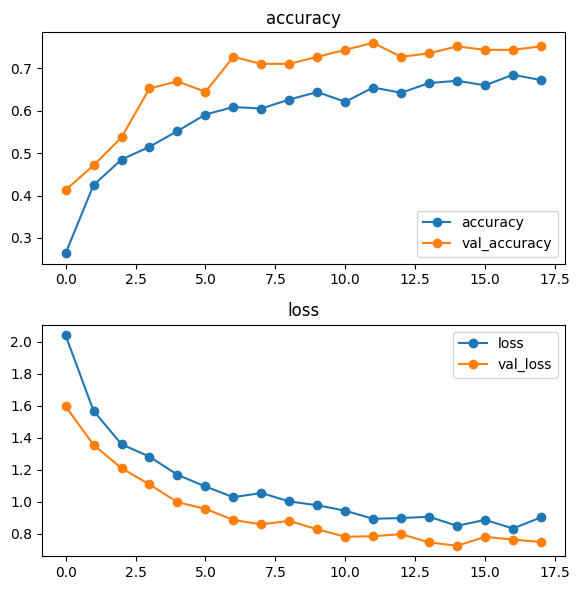

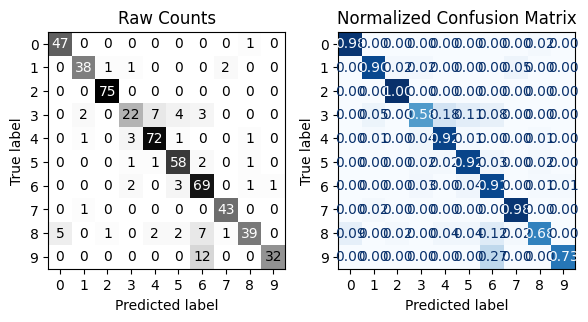

----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      1.00      0.83        10
           1       0.78      0.78      0.78         9
           2       0.88      0.94      0.91        16
           3       0.86      0.67      0.75         9
           4       0.83      0.94      0.88        16
           5       0.67      0.77      0.71        13
           6       0.59      0.62      0.61        16
           7       0.90      0.90      0.90        10
           8       1.00      0.17      0.29        12
           9       0.58      0.70      0.64        10

    accuracy                           0.75       121
   macro avg       0.78      0.75      0.73       121
weighted avg       0.78      0.75      0.73       121



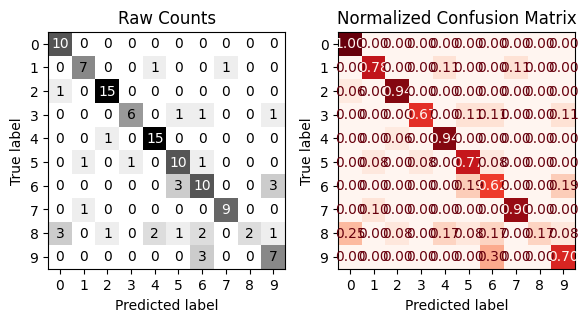

precision    recall  f1-score     support
Train 0              0.903846  0.979167  0.940000   48.000000
      1              0.904762  0.904762  0.904762   42.000000
      2              0.974026  1.000000  0.986842   75.000000
      3              0.758621  0.578947  0.656716   38.000000
      4              0.878049  0.923077  0.900000   78.000000
      5              0.852941  0.920635  0.885496   63.000000
      6              0.741935  0.907895  0.816568   76.000000
      7              0.934783  0.977273  0.955556   44.000000
      8              0.906977  0.684211  0.780000   57.000000
      9              0.969697  0.727273  0.831169   44.000000
      accuracy       0.876106  0.876106  0.876106    0.876106
      macro avg      0.882564  0.860324  0.865711  565.000000
      weighted avg   0.880299  0.876106  0.872937  565.000000
Test  0              0.714286  1.000000  0.833333   10.000000
      1              0.777778  0.777778  0.777778    9.000000
      2              0.882353  0.937500  0.909091   16.000000
      3              0.857143  0.666667  0.750000    9.000000
      4              0.833333  0.937500  0.882353   16.000000
      5              0.666667  0.769231  0.714286   13.000000
      6              0.588235  0.625000  0.606061   16.000000
      7              0.900000  0.900000  0.900000   10.000000
      8              1.000000  0.166667  0.285714   12.000000
      9              0.583333  0.700000  0.636364   10.000000
      accuracy       0.752066  0.752066  0.752066    0.752066
      macro avg      0.780313  0.748034  0.729498  121.000000
      weighted avg   0.778677  0.752066  0.731581  121.000000

In [ ]:
# Evaluate the results

train_dict, test_dict = evaluate_classification_network(model_7_dropout,
                                                        X_train=train_ds,
                                                        X_test=test_ds,
                                                        history=history_7,
                                                        output_dict=True)

# Use helper function to get results in a DataFrame

results_model_7 = make_results_df(train_dict, test_dict)
results_model_7

In [ ]:
# Use helper function to compare the current model with the best previous model (model #3)

compare_models(results_model_3, results_model_7)

Train accuracy decreased by -0.046017699115044164
Test accuracy decreased by -0.11570247933884292
Overfitting increased by 0.06968478022379876
*Overfitting is calculated as train accuracy - test acccuracy


Observation:

After adding the dropout layer, test is now performing better than train. This is not too surprising because during training neurons were randomly turned off, which makes predicting harder, but all neurons are used during test, which allows it to utilize the entire model. Overall, adding the dropout layer greatly decreased the test accuracy, and overfitting became worse. If the overfitting was not serious in the first place, the dropout layer can hurt performance. I will remove the dropout layer for now and continue to explore other ways to address overfitting.

-------
# Model 8: Reduce Overfitting

### a) (KEEP) Reduce model complexity: change 32 units to 16
### b) (KEEP) Add data augmentation to prevent the model from memorizing fixed patterns
### c) (REMOVE) Remove RandomTranslation, Remove RandomContrast
### d) (REMOVE) Add Dropout Layer
### e) (NEW) Add BatchNormalization

-------

In [ ]:
# Define a data augmentation layer

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
], name='data_augmentation')


# Build model

def build_model_8_batchnorm():
  model = Sequential()
  model.add(Input(shape=INPUT_SHAPE))
  model.add(data_augmentation)
  model.add(Lambda(resnetv2_preprocessor))
  model.add(resnet50v2_pretrained)
  model.add(Dense(16, activation=None))
  model.add(BatchNormalization())
  model.add(ReLU())
  model.add(Dense(len(class_names), activation='softmax'))

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  model.summary()
  return model


# Make an instance of the model

model_8_batchnorm = build_model_8_batchnorm()
model_8_batchnorm.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_11 (Lambda)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 2048)           │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 16)             │        32,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,597,818 (90.02 MB)

 Trainable params: 32,986 (128.85 KB)

 Non-trainable params: 23,564,832 (89.89 MB)

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_11 (Lambda)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 2048)           │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 16)             │        32,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,597,818 (90.02 MB)

 Trainable params: 32,986 (128.85 KB)

 Non-trainable params: 23,564,832 (89.89 MB)

In [ ]:
# Fit the model

history_8 = model_8_batchnorm.fit(train_ds, validation_data=test_ds, epochs=30,
                                callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])

Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.2239 - loss: 2.2127 - val_accuracy: 0.4793 - val_loss: 1.4917
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5977 - loss: 1.5055 - val_accuracy: 0.5868 - val_loss: 1.2842
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7217 - loss: 1.3020 - val_accuracy: 0.7355 - val_loss: 1.1096
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7945 - loss: 1.1058 - val_accuracy: 0.8099 - val_loss: 1.0047
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8370 - loss: 0.9683 - val_accuracy: 0.8182 - val_loss: 0.9057
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8264 - loss: 0.9013 - val_accuracy: 0.8182 - val_loss: 0.8714
Epoch 7/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8313 - loss: 0.7893 - val_accuracy: 0.8182 - val_loss: 0.8611
Epoch 8/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9014 - loss: 0.6669 - val_accuracy: 0.8595 - 


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        48
           1       1.00      1.00      1.00        42
           2       1.00      1.00      1.00        75
           3       0.87      0.87      0.87        38
           4       1.00      0.92      0.96        78
           5       0.92      0.97      0.95        63
           6       0.95      0.92      0.93        76
           7       1.00      1.00      1.00        44
           8       0.92      1.00      0.96        57
           9       1.00      1.00      1.00        44

    accuracy                           0.97       565
   macro avg       0.97      0.97      0.97       565
weighted avg       0.97      0.97      0.97       565



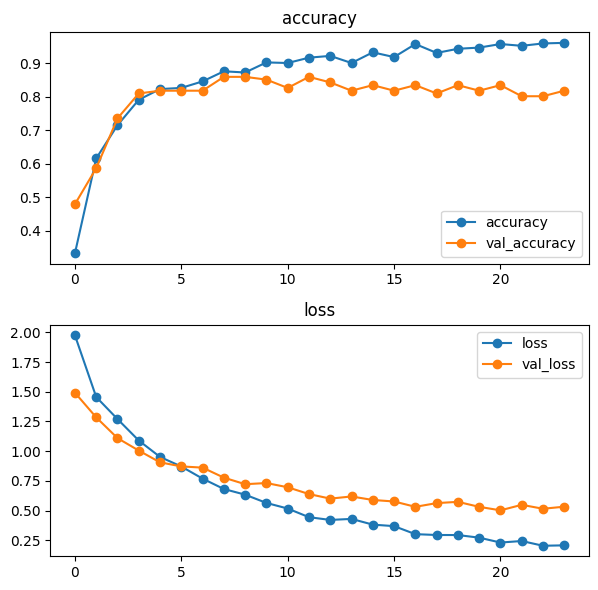

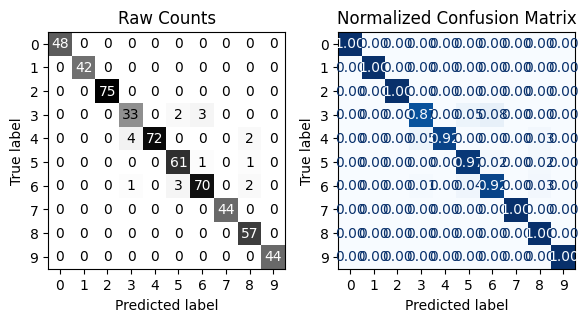

----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.89      0.94         9
           2       0.94      1.00      0.97        16
           3       0.75      0.33      0.46         9
           4       1.00      0.75      0.86        16
           5       0.56      0.77      0.65        13
           6       0.87      0.81      0.84        16
           7       0.91      1.00      0.95        10
           8       0.71      0.83      0.77        12
           9       0.77      1.00      0.87        10

    accuracy                           0.83       121
   macro avg       0.85      0.83      0.83       121
weighted avg       0.85      0.83      0.83       121



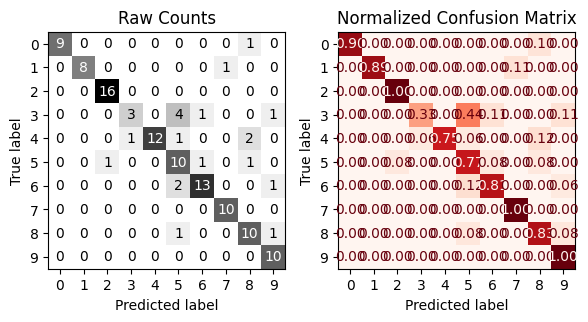

precision    recall  f1-score     support
Train 0              1.000000  1.000000  1.000000   48.000000
      1              1.000000  1.000000  1.000000   42.000000
      2              1.000000  1.000000  1.000000   75.000000
      3              0.868421  0.868421  0.868421   38.000000
      4              1.000000  0.923077  0.960000   78.000000
      5              0.924242  0.968254  0.945736   63.000000
      6              0.945946  0.921053  0.933333   76.000000
      7              1.000000  1.000000  1.000000   44.000000
      8              0.919355  1.000000  0.957983   57.000000
      9              1.000000  1.000000  1.000000   44.000000
      accuracy       0.966372  0.966372  0.966372    0.966372
      macro avg      0.965796  0.968080  0.966547  565.000000
      weighted avg   0.967296  0.966372  0.966371  565.000000
Test  0              1.000000  0.900000  0.947368   10.000000
      1              1.000000  0.888889  0.941176    9.000000
      2              0.941176  1.000000  0.969697   16.000000
      3              0.750000  0.333333  0.461538    9.000000
      4              1.000000  0.750000  0.857143   16.000000
      5              0.555556  0.769231  0.645161   13.000000
      6              0.866667  0.812500  0.838710   16.000000
      7              0.909091  1.000000  0.952381   10.000000
      8              0.714286  0.833333  0.769231   12.000000
      9              0.769231  1.000000  0.869565   10.000000
      accuracy       0.834711  0.834711  0.834711    0.834711
      macro avg      0.850601  0.828729  0.825197  121.000000
      weighted avg   0.853325  0.834711  0.831275  121.000000

In [ ]:
# Evaluate the results

train_dict, test_dict = evaluate_classification_network(model_8_batchnorm,
                                                        X_train=train_ds,
                                                        X_test=test_ds,
                                                        history=history_8,
                                                        output_dict=True)

# Use helper function to get results in a DataFrame

results_model_8 = make_results_df(train_dict, test_dict)
results_model_8

In [ ]:
# Use helper function to compare the current model with the best previous model (model #3)

compare_models(results_model_3, results_model_8)

Train accuracy increased by 0.04424778761061954
Test accuracy decreased by -0.03305785123966942
Overfitting increased by 0.07730563885028896
*Overfitting is calculated as train accuracy - test acccuracy


Observation:

Adding BatchNormalization also did not help with overfitting, but this is not too surprising, as BatchNormalization only introduces a little bit of regularization by adding noice during training due to per-batch statistics. Next, I will try to use L2-regularization instead to reduce overfitting.

-------
# Model 9: Reduce Overfitting

### a) (KEEP) Reduce model complexity: change 32 units to 16
### b) (KEEP) Add data augmentation to prevent the model from memorizing fixed patterns
### c) (REMOVE) Remove RandomTranslation, Remove RandomContrast
### d) (REMOVE) Add Dropout Layer
### e) (REMOVE) Add BatchNormalization
### f) (NEW) Add L2 Regularization

-------

In [ ]:
# Define a data augmentation layer

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
], name='data_augmentation')


# Build model

def build_model_9_l2():
  model = Sequential()
  model.add(Input(shape=INPUT_SHAPE))
  model.add(data_augmentation)
  model.add(Lambda(resnetv2_preprocessor))
  model.add(resnet50v2_pretrained)
  model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.001)))
  model.add(Dense(len(class_names), activation='softmax'))

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  model.summary()
  return model


# Make an instance of the model

model_9_l2 = build_model_9_l2()
model_9_l2.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_13 (Lambda)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 2048)           │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 16)             │        32,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,597,754 (90.02 MB)

 Trainable params: 32,954 (128.73 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_13 (Lambda)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 2048)           │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 16)             │        32,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,597,754 (90.02 MB)

 Trainable params: 32,954 (128.73 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [ ]:
# Fit the model

history_9 = model_9_l2.fit(train_ds, validation_data=test_ds, epochs=30,
                                callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])

Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.1986 - loss: 2.2786 - val_accuracy: 0.3471 - val_loss: 1.8956
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3879 - loss: 1.7529 - val_accuracy: 0.4959 - val_loss: 1.5660
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5736 - loss: 1.4293 - val_accuracy: 0.5537 - val_loss: 1.3219
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5911 - loss: 1.2342 - val_accuracy: 0.5868 - val_loss: 1.1781
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5799 - loss: 1.1215 - val_accuracy: 0.6529 - val_loss: 1.0468
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6559 - loss: 0.9610 - val_accuracy: 0.7438 - val_loss: 0.9430
Epoch 7/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7746 - loss: 0.7553 - val_accuracy: 0.7686 - val_loss: 0.7896
Epoch 8/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8192 - loss: 0.6381 - val_accuracy: 0.7438 -


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.96      0.95        48
           1       0.95      0.98      0.96        42
           2       1.00      0.96      0.98        75
           3       0.85      0.61      0.71        38
           4       0.90      0.88      0.89        78
           5       0.87      0.97      0.92        63
           6       0.88      0.91      0.90        76
           7       1.00      0.98      0.99        44
           8       0.84      0.91      0.87        57
           9       0.95      0.95      0.95        44

    accuracy                           0.92       565
   macro avg       0.92      0.91      0.91       565
weighted avg       0.92      0.92      0.92       565



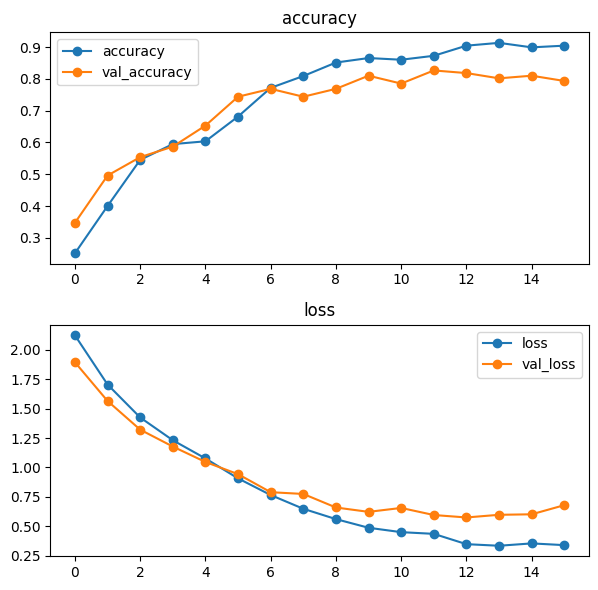

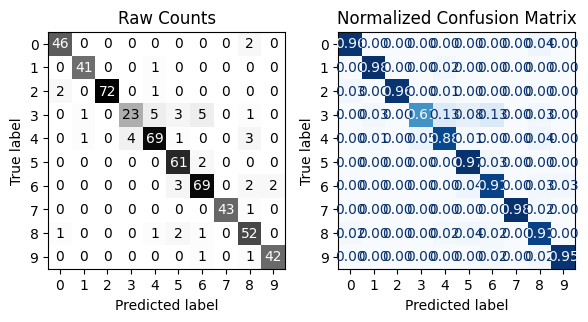

----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       0.89      0.89      0.89         9
           2       1.00      0.94      0.97        16
           3       0.71      0.56      0.62         9
           4       0.76      0.81      0.79        16
           5       0.67      0.92      0.77        13
           6       0.80      0.75      0.77        16
           7       0.91      1.00      0.95        10
           8       0.83      0.42      0.56        12
           9       0.82      0.90      0.86        10

    accuracy                           0.82       121
   macro avg       0.82      0.82      0.81       121
weighted avg       0.82      0.82      0.81       121



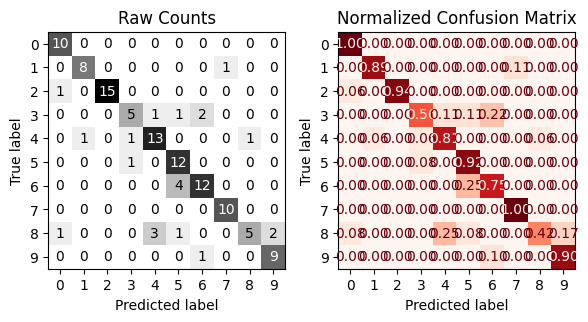

precision    recall  f1-score     support
Train 0              0.938776  0.958333  0.948454   48.000000
      1              0.953488  0.976190  0.964706   42.000000
      2              1.000000  0.960000  0.979592   75.000000
      3              0.851852  0.605263  0.707692   38.000000
      4              0.896104  0.884615  0.890323   78.000000
      5              0.871429  0.968254  0.917293   63.000000
      6              0.884615  0.907895  0.896104   76.000000
      7              1.000000  0.977273  0.988506   44.000000
      8              0.838710  0.912281  0.873950   57.000000
      9              0.954545  0.954545  0.954545   44.000000
      accuracy       0.916814  0.916814  0.916814    0.916814
      macro avg      0.918952  0.910465  0.912116  565.000000
      weighted avg   0.917365  0.916814  0.915138  565.000000
Test  0              0.833333  1.000000  0.909091   10.000000
      1              0.888889  0.888889  0.888889    9.000000
      2              1.000000  0.937500  0.967742   16.000000
      3              0.714286  0.555556  0.625000    9.000000
      4              0.764706  0.812500  0.787879   16.000000
      5              0.666667  0.923077  0.774194   13.000000
      6              0.800000  0.750000  0.774194   16.000000
      7              0.909091  1.000000  0.952381   10.000000
      8              0.833333  0.416667  0.555556   12.000000
      9              0.818182  0.900000  0.857143   10.000000
      accuracy       0.818182  0.818182  0.818182    0.818182
      macro avg      0.822849  0.818419  0.809207  121.000000
      weighted avg   0.824269  0.818182  0.810077  121.000000

In [ ]:
# Evaluate the results

train_dict, test_dict = evaluate_classification_network(model_9_l2,
                                                        X_train=train_ds,
                                                        X_test=test_ds,
                                                        history=history_9,
                                                        output_dict=True)

# Use helper function to get results in a DataFrame

results_model_9 = make_results_df(train_dict, test_dict)
results_model_9

In [ ]:
# Use helper function to compare the current model with the best previous model (model #3)

compare_models(results_model_3, results_model_9)

Train accuracy decreased by -0.005309734513274322
Test accuracy decreased by -0.04958677685950408
Overfitting increased by 0.044277042346229756
*Overfitting is calculated as train accuracy - test acccuracy


Observation:

After adding L2 regularization, both train and test accuracy decreased. Overfitting also increased. I will remove L2 regularization for now, and continue testing other methods of reducing overfitting.

-------
# Model 10: Reduce Overfitting

### a) (KEEP) Reduce model complexity: change 32 units to 16
### b) (KEEP) Add data augmentation to prevent the model from memorizing fixed patterns
### c) (REMOVE) Remove RandomTranslation, Remove RandomContrast
### d) (REMOVE) Add Dropout Layer
### e) (REMOVE) Add BatchNormalization
### f) (REMOVE) Add L2 Regularization
### g) (NEW) Add label smoothing

-------

In [ ]:
# Change labels to one hot encoded in order to utilize CategoricalCrossentropy, because SparseCategoricalCrossentropy does not have label_smoothing

num_classes = len(class_names)

# Map each (x, y) → (x, one_hot(y))
train_ds_oh = train_ds.map(
    lambda x, y: (
        x,
        tf.one_hot(tf.cast(y, tf.int32), depth=num_classes)
    )
)

test_ds_oh = test_ds.map(
    lambda x, y: (
        x,
        tf.one_hot(tf.cast(y, tf.int32), depth=num_classes)
    )
)

In [ ]:
# Define loss function with label_smoothing

loss_fn = tf.keras.losses.CategoricalCrossentropy(
    from_logits=False,
    label_smoothing=0.1
)

# Define a data augmentation layer

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
], name='data_augmentation')


# Build model

def build_model_10_smoothing():
  model = Sequential()
  model.add(Input(shape=INPUT_SHAPE))
  model.add(data_augmentation)
  model.add(Lambda(resnetv2_preprocessor))
  model.add(resnet50v2_pretrained)
  model.add(Dense(16, activation='relu'))
  model.add(Dense(len(class_names), activation='softmax'))

  model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

  model.summary()
  return model


# Make an instance of the model

model_10_smoothing = build_model_10_smoothing()
model_10_smoothing.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_16 (Lambda)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 2048)           │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 16)             │        32,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,597,754 (90.02 MB)

 Trainable params: 32,954 (128.73 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_16 (Lambda)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 2048)           │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 16)             │        32,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,597,754 (90.02 MB)

 Trainable params: 32,954 (128.73 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [ ]:
# Fit the model

history_10 = model_10_smoothing.fit(train_ds_oh, validation_data=test_ds_oh, epochs=30,
                                callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])

Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.2185 - loss: 2.3594 - val_accuracy: 0.4050 - val_loss: 1.9239
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5076 - loss: 1.7252 - val_accuracy: 0.5702 - val_loss: 1.5272
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6525 - loss: 1.3489 - val_accuracy: 0.7273 - val_loss: 1.1816
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7580 - loss: 1.0990 - val_accuracy: 0.7438 - val_loss: 1.0963
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8032 - loss: 1.0046 - val_accuracy: 0.8017 - val_loss: 1.0659
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8606 - loss: 0.9111 - val_accuracy: 0.7934 - val_loss: 1.0895
Epoch 7/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8423 - loss: 0.9128 - val_accuracy: 0.7603 - val_loss: 1.0802
Epoch 8/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8568 - loss: 0.8905 - val_accuracy: 0.8099 - 


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        48
           1       0.98      0.95      0.96        42
           2       0.99      0.96      0.97        75
           3       0.89      0.63      0.74        38
           4       0.91      0.92      0.92        78
           5       0.92      0.97      0.95        63
           6       0.89      0.99      0.94        76
           7       1.00      1.00      1.00        44
           8       0.93      0.95      0.94        57
           9       0.98      0.93      0.95        44

    accuracy                           0.94       565
   macro avg       0.94      0.93      0.93       565
weighted avg       0.94      0.94      0.94       565



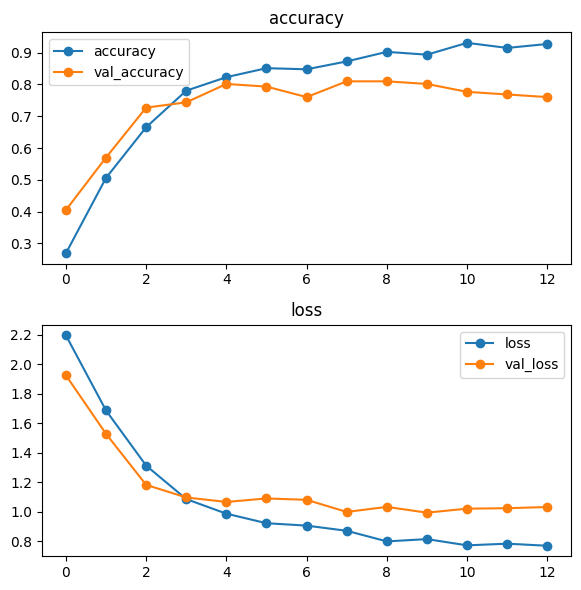

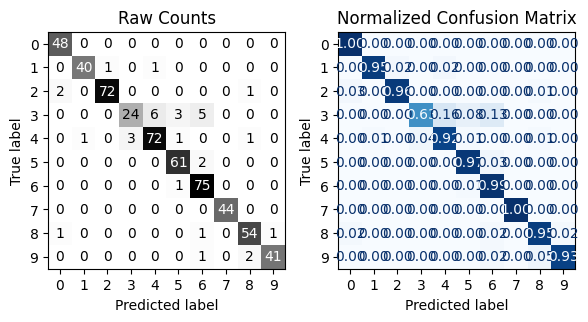

----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.67      1.00      0.80        10
           1       1.00      0.78      0.88         9
           2       1.00      0.88      0.93        16
           3       0.50      0.33      0.40         9
           4       1.00      0.88      0.93        16
           5       0.62      0.77      0.69        13
           6       0.74      0.88      0.80        16
           7       0.83      1.00      0.91        10
           8       0.78      0.58      0.67        12
           9       0.89      0.80      0.84        10

    accuracy                           0.80       121
   macro avg       0.80      0.79      0.78       121
weighted avg       0.82      0.80      0.80       121



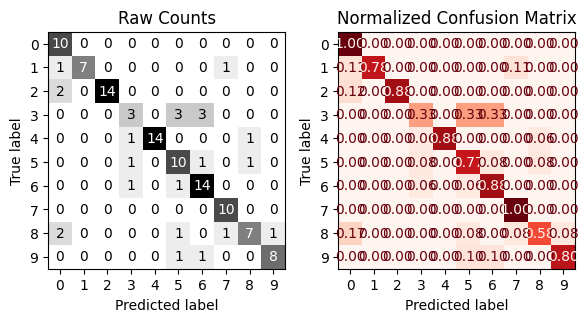

precision    recall  f1-score     support
Train 0              0.941176  1.000000  0.969697   48.000000
      1              0.975610  0.952381  0.963855   42.000000
      2              0.986301  0.960000  0.972973   75.000000
      3              0.888889  0.631579  0.738462   38.000000
      4              0.911392  0.923077  0.917197   78.000000
      5              0.924242  0.968254  0.945736   63.000000
      6              0.892857  0.986842  0.937500   76.000000
      7              1.000000  1.000000  1.000000   44.000000
      8              0.931034  0.947368  0.939130   57.000000
      9              0.976190  0.931818  0.953488   44.000000
      accuracy       0.939823  0.939823  0.939823    0.939823
      macro avg      0.942769  0.930132  0.933804  565.000000
      weighted avg   0.939994  0.939823  0.937909  565.000000
Test  0              0.666667  1.000000  0.800000   10.000000
      1              1.000000  0.777778  0.875000    9.000000
      2              1.000000  0.875000  0.933333   16.000000
      3              0.500000  0.333333  0.400000    9.000000
      4              1.000000  0.875000  0.933333   16.000000
      5              0.625000  0.769231  0.689655   13.000000
      6              0.736842  0.875000  0.800000   16.000000
      7              0.833333  1.000000  0.909091   10.000000
      8              0.777778  0.583333  0.666667   12.000000
      9              0.888889  0.800000  0.842105   10.000000
      accuracy       0.801653  0.801653  0.801653    0.801653
      macro avg      0.802851  0.788868  0.784918  121.000000
      weighted avg   0.815179  0.801653  0.798505  121.000000

In [ ]:
# Evaluate the results

train_dict, test_dict = evaluate_classification_network(model_10_smoothing,
                                                        X_train=train_ds_oh,
                                                        X_test=test_ds_oh,
                                                        history=history_10,
                                                        output_dict=True)

# Use helper function to get results in a DataFrame

results_model_10 = make_results_df(train_dict, test_dict)
results_model_10

In [ ]:
# Use helper function to compare the current model with the best previous model (model #3)

compare_models(results_model_3, results_model_10)

Train accuracy increased by 0.017699115044247815
Test accuracy decreased by -0.06611570247933884
Overfitting increased by 0.08381481752358666
*Overfitting is calculated as train accuracy - test acccuracy
